# Experiment 1 - Oversampling

In [1]:
import os
from os.path import join, basename, dirname, exists, split, splitext
from glob import glob

from natsort import natsorted
import yaml
import shutil
import argparse

In [2]:
PATCH_DIR = "../04-Data/patches_1024"

In [3]:
train_targets_path = os.path.join(PATCH_DIR, 'train_targets_patches')
train_images_path = os.path.join(PATCH_DIR, 'train_images_patches')

val_targets_path = join(PATCH_DIR, 'val_targets_patches')
val_images_path = join(PATCH_DIR, 'val_images_patches')

train_images_list = glob(join(train_images_path, "**", "*.png"),recursive=True)
train_images_list = natsorted(train_images_list, key=lambda y: y.lower())
train_targets_list = glob(join(train_targets_path, "**", "*.txt"),recursive=True)
train_targets_list = natsorted(train_targets_list, key=lambda y: y.lower())

In [4]:
def extract_hbb(pxl_coordinates: list):
    '''
    Creates a dictionary of bounding box information and returns a list of dictionaries containing bounding box information

    pxl_coordinates: List of strings
    '''
    bounding_boxes=[]
    for location in pxl_coordinates: 
        parts = location.strip().split()
        bounding_boxes.append({'label': parts[-2],
                              'x1': float(parts[0]), 
                              'y1': float(parts[1]), 
                              'x2': float(parts[2]), 
                              'y2': float(parts[3]), 
                              'x3': float(parts[4]), 
                              'y3': float(parts[5]), 
                              'x4': float(parts[6]), 
                              'y4': float(parts[7]), 
                              'difficulty': int(parts[-1])})
    return bounding_boxes

def read_txt(path):
    '''
    Reads .txt files and returns a list of strings (lines of the .txt file)

    path: Path to .txt file
    '''
    with open(path, 'r') as file:
        lines = file.readlines()
    return lines

In [8]:
def oversample(image_list, target_list, n = 0):
    """
    n: int ... How many copies of difficult images are to be made -> Oversample factor
    """
    counter_diff = 0
    counter_extra = 0
    counter_easy = 0
    NEW_PATCH_DIR = PATCH_DIR + f"_os_{n}"

    new_image_dir = join(NEW_PATCH_DIR, "train_images_patches")
    new_target_dir = join(NEW_PATCH_DIR, "train_targets_patches")

    new_val_image_dir = join(NEW_PATCH_DIR, "val_images_patches")
    new_val_target_dir = join(NEW_PATCH_DIR, "val_targets_patches")

    shutil.copytree(val_images_path, new_val_image_dir)
    shutil.copytree(val_targets_path, new_val_target_dir)

    if not exists(new_image_dir):
        os.makedirs(new_image_dir)
    if not exists(new_target_dir):
        os.makedirs(new_target_dir)

    for i, (image, target) in enumerate(zip(image_list, target_list)):
        diff = False
        data = read_txt(target)
        data = extract_hbb(data)
        diff = any(bbox["difficulty"] == 1 for bbox in data)
        if diff:
            _, filename_image = split(image)
            _, filename_target = split(target)
            name_image, extension_image = splitext(filename_image)
            name_target, extension_target = splitext(filename_target)
            new_image_path = join(NEW_PATCH_DIR, "train_images_patches", filename_image)
            new_target_path = join(NEW_PATCH_DIR, "train_targets_patches", filename_target)

            shutil.copyfile(image, new_image_path)
            shutil.copyfile(target, new_target_path)

            counter_diff += 1
            
            for j in range(n):
                image_copy = f"{name_image}_copy{j}{extension_image}"
                image_copy_path = join(new_image_dir, image_copy)
                target_copy = f"{name_target}_copy{j}{extension_target}"
                target_copy_path = join(new_target_dir, target_copy)

                shutil.copyfile(image, image_copy_path)
                shutil.copyfile(target, target_copy_path)
                
                counter_extra += 1

        else:
            _, filename_image = split(image)
            _, filename_target = split(target)
            name_image, extension_image = splitext(filename_image)
            name_target, extension_target = splitext(filename_target)
            new_image_path = join(NEW_PATCH_DIR, "train_images_patches", filename_image)
            new_target_path = join(NEW_PATCH_DIR, "train_targets_patches", filename_target)

            shutil.copyfile(image, new_image_path)
            shutil.copyfile(target, new_target_path)

            counter_easy += 1

        if i == 10:
            break
    
    print(f"DIFF: {counter_diff}")
    print(f"EASY: {counter_easy}")
    print(f"SUM orignal dataset: {counter_diff + counter_easy}\n")
    print(f"Oversampling factor: {n}")
    print(f"Copied difficult images: {counter_extra}")
    print(f"SUM augmented dataset: {counter_diff + counter_easy + counter_extra}\n")
    print(f"Ratio of difficult images in original dataset: {round(100 * counter_diff / (counter_diff + counter_easy), 2)}%")
    print(f"Ratio of difficult images in augmented dataset: {round(100 * (counter_diff + counter_extra) / (counter_diff + counter_easy + counter_extra), 2)}%")
    



In [9]:
# oversample(train_images_list, train_targets_list, 1)

In [14]:
PATCH_DIR = "../04-Data/patches_1024_os_1"
train_targets_path = os.path.join(PATCH_DIR, 'train_targets_patches')
train_images_path = os.path.join(PATCH_DIR, 'train_images_patches')

val_targets_path = join(PATCH_DIR, 'val_targets_patches')
val_images_path = join(PATCH_DIR, 'val_images_patches')

train_images_list = glob(join(train_images_path, "**", "*.png"),recursive=True)
train_images_list = natsorted(train_images_list, key=lambda y: y.lower())
train_targets_list = glob(join(train_targets_path, "**", "*.txt"),recursive=True)
train_targets_list = natsorted(train_targets_list, key=lambda y: y.lower())

# Experiment 2 - Copying hard to detect instances

The goal is to create a dataset where every original image has **N** augmented copies, where all hard to detect images are copied once.

In [8]:
import os
from os.path import join, basename, dirname, exists, split, splitext
from glob import glob
import random
import time
import cv2 as cv

from natsort import natsorted
import yaml
import shutil
import argparse

from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [6]:
class ToTensor(object):
    def __call__(self, image):
        image = np.array(image)
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        image = image.float()/255.0        
        
        return image

In [7]:
class DotaDataset(Dataset):
    def __init__(self, images_path, targets_path, transform = ToTensor()):
        
        self.images_path = images_path
        self.targets_path = targets_path
        self.transform = transform
  
        self.class_to_idx = {
               "ship" : 0, 
               "storage-tank" : 1, 
               "baseball-diamond" : 2, 
               "tennis-court" : 3, 
               "basketball-court" : 4, 
               "ground-track-field" : 5, 
               "bridge" : 6, 
               "large-vehicle" : 7, 
               "small-vehicle" : 8, 
               "helicopter" : 9, 
               "swimming-pool" : 10, 
               "roundabout" : 11, 
               "soccer-ball-field" : 12, 
               "plane" : 13, 
               "harbor" : 14,
               "container-crane" : 15,
               "no_object": 16}

        self.colors = {
            'container-crane': 'blue',
            'ship': 'teal',
            'storage-tank': 'green',
            'baseball-diamond': 'yellow',
            'tennis-court': 'purple',
            'basketball-court': 'orange',
            'ground-track-field': 'pink',
            'bridge': 'turquoise',
            'large-vehicle': 'brown',
            'small-vehicle': 'azure',
            'helicopter': 'lime',
            'swimming-pool': 'cyan',
            'roundabout': 'magenta',
            'soccer-ball-field': 'gold',
            'plane': 'lime',
            'harbor': 'indigo'}

    def __len__(self):
        return(len(self.images_path))

    def __getitem__(self, idx):
        image = Image.open(self.images_path[idx])
        target = self.targets_path[idx]
        if self.transform:
            image = self.transform(image)

        hbb=self.read_txt(self.targets_path[idx])
        hbb=self.extract_hbb(hbb)

        boxes = []
        labels = []

        # What happens if boxes and labels are empty lists? Does this work during training?
        for box in hbb:
            xmin, xmax, ymin, ymax, label = box['x_min'], box['x_max'], box['y_min'], box['y_max'], box['label']
            boxes.append([xmin, ymin, xmax, ymax])
            id = self.class_to_idx[label]
            labels.append(id)
        
        if len(boxes) == 0:
            boxes.append([0, 0, 0, 0])  # Dummy box
            labels.append(-1)            # Dummy label
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        targets = {
        "boxes": boxes,
        "labels": labels}
        
        return image, targets

    def read_txt(self, path):
        '''
        Reads a text file
        Returns a list of lines in the text file
        path: Path to text file
        '''
        with open(path, 'r') as file:
            lines = file.readlines()
        return lines

    def get_image_path(self, idx):
        '''
        Returns image path at the index
        idx: Index of image path to return
        '''
        return self.images_path[idx]

    def get_unique_labels(self, target_path):
        '''
        Returns the unique labels of targets in an image
        taget_path: Path to the target
        '''
        unique_names = set()
        txt_file=self.read_txt(target_path)
        hbb_list=self.extract_hbb(txt_file)
        for d in hbb_list:
            name = d["label"]
            unique_names.add(name)
        unique_names=list(unique_names)
        return unique_names

    def create_custom_legend(self, labels,axes):
        '''
        Creates a legend for the objects in an image
        labels: Labels of the objects
        '''
        bbox_to_anchor=(1.04, 1)
        handles = []
        color_list=[]
        for label in labels:
            color_list.append(self.colors[label])
        for color, label in zip(color_list, labels):
            handle = Rectangle((0, 0), 1, 1, color=color, label=label)
            handles.append(handle)
        axes.legend(handles=handles,  loc="upper left", bbox_to_anchor=bbox_to_anchor)

    def extract_hbb(self, pxl_coordinates: list):
        '''
        Returns a dictionary of bounding box coordinates from a text file
        pxl_coordinates: List of bounding box strings
        '''
        bounding_boxes=[]
        for location in pxl_coordinates:
            parts = location.strip().split()
            x_min=float(parts[0])
            y_min=float(parts[1])
            x_max=float(parts[4])
            y_max=float(parts[5])
            class_label=parts[8]
            diff = parts[-1]
            bounding_boxes.append({'label':class_label,
                                  'x_min':x_min,
                                  'y_min':y_min,
                                  'x_max':x_max,
                                  'y_max':y_max,
                                  'diff': diff})
        return bounding_boxes

    def get_number_of_instances(self, target_path):
        '''
        Returns the number of objects in an image.
        target_path: Path to the target of the image
        '''
        unique_names=self.get_unique_labels(target_path)
        txt_file=self.read_txt(target_path)
        hbb_list=self.extract_hbb(txt_file)
        dic={item: 0  for item in unique_names}
        for box in hbb_list:
            if box["label"] in dic.keys():
                dic[box["label"]]+=1
        return dic

    def visualize(self, idx):
        '''
        Shows the image at the index and the objects 
        idx: Index of image to display
        '''
        print("Image path: " + self.images_path[idx])
        print("Target path: " + self.targets_path[idx])
    
        image = Image.open(self.images_path[idx])
    
        fig, ax = plt.subplots()
        ax.imshow(image)
        ax.axis('off')
        hbb=self.read_txt(self.targets_path[idx])
        hbb=self.extract_hbb(hbb)
        for box in hbb:
            if box['label'] in self.colors:
                color=self.colors[box['label']]
            if int(box["diff"]) == 1:
                color = "red"
            xmin, xmax, ymin, ymax, label = box['x_min'], box['x_max'], box['y_min'], box['y_max'], box['label']
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
        self.create_custom_legend(self.get_unique_labels(self.targets_path[idx]),ax)
        plt.savefig("HEHE.png", dpi = 300, bbox_inches='tight')
        plt.show()
        example=self.get_number_of_instances(self.targets_path[idx])
        for key, value in example.items():
            print(f"{key}: {value}")
        print("\n")

In [165]:
PATCH_DIR = "../04-Data/patches_1024"#_c_1"

In [166]:
train_targets_path = os.path.join(PATCH_DIR, 'train_targets_patches')
train_images_path = os.path.join(PATCH_DIR, 'train_images_patches')

val_targets_path = join(PATCH_DIR, 'val_targets_patches')
val_images_path = join(PATCH_DIR, 'val_images_patches')

test_images_path = join(PATCH_DIR, 'test_images_patches')
test_targets_path = join(PATCH_DIR, 'test_targets_patches')

test_images_list = glob(join(test_images_path, "**", "*.png"),recursive=True)
test_images_list = natsorted(test_images_list, key=lambda y: y.lower())
test_targets_list = glob(join(test_targets_path, "**", "*.txt"),recursive=True)
test_targets_list = natsorted(test_targets_list, key=lambda y: y.lower())

train_images_list = glob(join(train_images_path, "**", "*.png"),recursive=True)
train_images_list = natsorted(train_images_list, key=lambda y: y.lower())
train_targets_list = glob(join(train_targets_path, "**", "*.txt"),recursive=True)
train_targets_list = natsorted(train_targets_list, key=lambda y: y.lower())

In [168]:
train_set = DotaDataset(train_images_list, train_targets_list)
test_set = DotaDataset(test_images_list, test_targets_list)

Image path: ../04-Data/patches_1024/test_images_patches/P1809/P1809_1024_OL-0_x-5120_y-2048.png
Target path: ../04-Data/patches_1024/test_targets_patches/P1809/P1809_1024_OL-0_x-5120_y-2048.txt


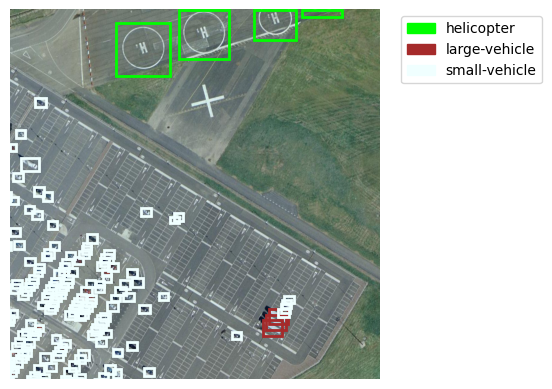

helicopter: 4
large-vehicle: 3
small-vehicle: 151




In [170]:
test_set.visualize(1607)

In [26]:
def copy_htd_instances(train_images_list, train_targets_list):

    copied_bboxes = 0
    copies = 0
    start_time = time.time()
    for i, (image, target) in enumerate(zip(train_images_list, train_targets_list)):
        print(f"{i+1}/{len(train_images_list)}", end = "\r")
        # Copies end on "copyx.png/copyx.txt"
        is_copy = splitext(basename(train_images_list[i]))[0].split("_")[-1].startswith("copy")
        if is_copy:
            data = read_txt(target)
            data = extract_hbb(data)
            copies += 1
    
            for i, bbox in enumerate(data):
                if bbox["difficulty"] == 1:
                    x_min=int(bbox["x1"])
                    y_min=int(bbox["y1"])
                    x_max=int(bbox["x3"])
                    y_max=int(bbox["y3"])
            
                    modified_image  = Image.open(image)
                    cropped = modified_image.crop((x_min, y_min, x_max, y_max))
                    bbox_width, bbox_height = cropped.size
                    
                    overlaps = True
                    while overlaps:
                        new_x_min = random.randint(0, modified_image.width - bbox_width) # so that copied bbox does not go over margin
                        new_y_min = random.randint(0, modified_image.height - bbox_height)
                        new_x_max = new_x_min + bbox_width
                        new_y_max = new_y_min + bbox_height
                        new_bbox = {
                            "x1": new_x_min,
                            "x3": new_x_max,
                            "y1": new_y_min,
                            "y3": new_y_max}
                        
                        overlaps = False
                        for existing_bbox in data:
                            if is_overlapping(new_bbox, existing_bbox):
                                overlaps = True
                                break
                            
                    
                    modified_image.paste(cropped, (new_x_min, new_y_min))
                    modified_image.save(image)
                    copied_bboxes += 1
                    new_bbox_dict = {
                            "x1": new_x_min,
                            "y1": new_y_min,
                            "x2": new_x_min + bbox_width,
                            "y2": new_y_min,
                            "x3": new_x_max,
                            "y3": new_y_max,
                            "x4": new_x_min,
                            "y4": new_y_min + bbox_height,
                            "label": bbox["label"],
                            "difficulty": bbox["difficulty"]}
                    new_bbox_entry = ""
                    for key, value in new_bbox_dict.items():
                        if key != "label" and key != "difficulty":
                            new_bbox_entry += str(float(value)) + " "
                        else:
                            new_bbox_entry += str(value) + " "
                
                    new_bbox_entry = new_bbox_entry.strip()
                    with open(target, 'a') as file:
                        file.write(new_bbox_entry + '\n')
    
    print(f"{len(train_images_list)}/{len(train_images_list)}")
    print(f"Copied {copied_bboxes} bounding boxes in {copies} images.")
    duration = round((time.time() - start_time)/60,2)
    print(f"Duration: {duration} minutes")

In [1]:
copy_htd_instances(train_images_list, train_targets_list)

In [74]:
image = "../04-Data/patches_1024_os_1/train_images_patches/P0000_1024_OL-256_x-768_y-0_copy0.png"
target = "../04-Data/patches_1024_os_1/train_targets_patches/P0000_1024_OL-256_x-768_y-0_copy0.txt"

In [28]:
def is_overlapping(new_box, existing_box):
    return not (
        new_box['x3'] < existing_box['x1'] or
        new_box['x1'] > existing_box['x3'] or
        new_box['y3'] < existing_box['y1'] or
        new_box['y1'] > existing_box['y3']
    )

In [236]:
data = read_txt(target)
data = extract_hbb(data)

for i, bbox in enumerate(data):
    if bbox["difficulty"] == 1:
        x_min=int(bbox["x1"])
        y_min=int(bbox["y1"])
        x_max=int(bbox["x3"])
        y_max=int(bbox["y3"])

        modified_image  = Image.open(image)
        cropped = modified_image.crop((x_min, y_min, x_max, y_max))
        bbox_width, bbox_height = cropped.size
        
        overlaps = True
        while overlaps:
            new_x_min = random.randint(0, modified_image.width - bbox_width) # so that copied bbox does not go over margin
            new_y_min = random.randint(0, modified_image.height - bbox_height)
            new_x_max = new_x_min + bbox_width
            new_y_max = new_y_min + bbox_height
            new_bbox = {
                "x1": new_x_min,
                "x3": new_x_max,
                "y1": new_y_min,
                "y3": new_y_max}
            
            overlaps = False
            for existing_bbox in data:
                if is_overlapping(new_bbox, existing_bbox):
                    overlaps = True
                    break
                    
            
        modified_image.paste(cropped, (new_x_min, new_y_min))
        modified_image.save(image)
        new_bbox_dict = {
                "x1": new_x_min,
                "y1": new_y_min,
                "x2": new_x_min + bbox_width,
                "y2": new_y_min,
                "x3": new_x_max,
                "y3": new_y_max,
                "x4": new_x_min,
                "y4": new_y_min + bbox_height,
                "label": bbox["label"],
                "difficulty": bbox["difficulty"]}
        new_bbox_entry = ""
        for key, value in new_bbox_dict.items():
            if key != "label" and key != "difficulty":
                new_bbox_entry += str(float(value)) + " "
            else:
                new_bbox_entry += str(value) + " "
    
        new_bbox_entry = new_bbox_entry.strip()
        with open(target, 'a') as file:
            file.write(new_bbox_entry + '\n')

                    

4 {'label': 'small-vehicle', 'x1': 167.0, 'y1': 88.0, 'x2': 187.0, 'y2': 88.0, 'x3': 187.0, 'y3': 104.0, 'x4': 167.0, 'y4': 104.0, 'difficulty': 1}


7 {'label': 'small-vehicle', 'x1': 25.0, 'y1': 354.0, 'x2': 37.0, 'y2': 354.0, 'x3': 37.0, 'y3': 370.0, 'x4': 25.0, 'y4': 370.0, 'difficulty': 1}


8 {'label': 'small-vehicle', 'x1': 49.0, 'y1': 361.0, 'x2': 62.0, 'y2': 361.0, 'x3': 62.0, 'y3': 376.0, 'x4': 49.0, 'y4': 376.0, 'difficulty': 1}


9 {'label': 'small-vehicle', 'x1': 123.0, 'y1': 1021.0, 'x2': 135.0, 'y2': 1021.0, 'x3': 135.0, 'y3': 1024.0, 'x4': 123.0, 'y4': 1024.0, 'difficulty': 1}


10 {'label': 'small-vehicle', 'x1': 797.0, 'y1': 1010.0, 'x2': 821.0, 'y2': 1010.0, 'x3': 821.0, 'y3': 1024.0, 'x4': 797.0, 'y4': 1024.0, 'difficulty': 1}


11 {'label': 'small-vehicle', 'x1': 796.0, 'y1': 1023.0, 'x2': 819.0, 'y2': 1023.0, 'x3': 819.0, 'y3': 1024.0, 'x4': 796.0, 'y4': 1024.0, 'difficulty': 1}


12 {'label': 'small-vehicle', 'x1': 231.0, 'y1': 62.0, 'x2': 243.0, 'y2': 62.0, 'x3'